# Fine-tune Transformer on Apache Logs

This notebook fine-tunes the OpenStack-trained model on **normal Apache logs** to learn:
- HTTP request patterns (GET, POST, PUT, DELETE)
- Common URL structures (/api/users, /static/*, /health)
- Status code distributions (200, 304, 404, 500)
- Normal user agent patterns

**Strategy:**
1. Extract only **normal logs** from synthetic dataset (no attacks)
2. Fine-tune the pre-trained model on Apache patterns
3. Save the adapted model for anomaly detection
4. Attacks will then appear as deviations from learned normal patterns

In [16]:
import json
import math
import re
from pathlib import Path
from collections import defaultdict, Counter
import yaml
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-darkgrid' if 'seaborn-v0_8-darkgrid' in plt.style.available else 'default')
%matplotlib inline

In [17]:
# Setup
CWD = Path.cwd().resolve()
REPO_ROOT = CWD.parent if CWD.name == 'notebooks' else CWD

cfg = yaml.safe_load((REPO_ROOT / 'configs/train_openstack.yaml').read_text())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Device: {device}")
print(f"Repo root: {REPO_ROOT}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Device: cuda
Repo root: /home/tpi/distil_shahreyar
GPU: Quadro RTX 6000
Memory: 25.19 GB


## 1. Load and Filter Normal Apache Logs

In [18]:
# Load synthetic logs and labels
log_file = REPO_ROOT / 'data/apache_logs/synthetic_nodejs_apache_10k.log'
label_file = REPO_ROOT / 'data/apache_logs/synthetic_apache_labels.json'

with open(label_file, 'r') as f:
    label_data = json.load(f)

ground_truth = label_data['labels']

print(f"Loading logs from: {log_file}")
print(f"Total logs: {label_data['metadata']['total_logs']:,}")
print(f"Normal logs: {label_data['metadata']['normal_logs']:,}")
print(f"Anomalous logs: {label_data['metadata']['anomalous_logs']:,}")

Loading logs from: /home/tpi/distil_shahreyar/data/apache_logs/synthetic_nodejs_apache_10k.log
Total logs: 10,050
Normal logs: 8,500
Anomalous logs: 1,500


In [19]:
# Apache log parser
APACHE_PATTERN = re.compile(
    r'^(?P<ip>\S+) \S+ \S+ '
    r'\[(?P<timestamp>[^\]]+)\] '
    r'"(?P<method>\S+) (?P<path>\S+) (?P<protocol>\S+)" '
    r'(?P<status>\d+) '
    r'(?P<size>\S+)'
    r'(?: "(?P<referrer>[^"]*)")?'
    r'(?: "(?P<user_agent>[^"]*)")?'
)

RE_IPv4 = re.compile(r'\b(?:(?:25[0-5]|2[0-4]\d|1?\d?\d)\.){3}(?:25[0-5]|2[0-4]\d|1?\d?\d)\b')
RE_NUM = re.compile(r'(?<![A-Za-z])[-+]?\d+(?:\.\d+)?(?![A-Za-z])')
RE_PATH = re.compile(r'(?:/[^/\s]+)+')
RE_URL = re.compile(r'https?://\S+')

def normalize_apache_message(msg: str) -> str:
    if not msg:
        return msg
    out = msg
    out = RE_URL.sub('<URL>', out)
    out = RE_IPv4.sub('<IP>', out)
    
    def normalize_path(match):
        path = match.group(0)
        path = re.sub(r'/\d+', '/<NUM>', path)
        path = re.sub(r'/[0-9a-fA-F]{8,}', '/<HEX>', path)
        return path
    
    out = RE_PATH.sub(normalize_path, out)
    
    def bucket_number(m):
        s = m.group(0)
        try:
            val = float(s) if '.' in s else int(s)
            if val == 0:
                return '<NUM_E0>'
            mag = int(math.floor(math.log10(abs(val))))
            return f'<NUM_E{mag}>'
        except:
            return '<NUM>'
    
    out = RE_NUM.sub(bucket_number, out)
    return re.sub(r'\s+', ' ', out).strip()

def parse_apache_log(log_path: Path, filter_normal_only=False):
    records = []
    with open(log_path, 'r', encoding='utf-8', errors='ignore') as f:
        for line_num, line in enumerate(f, 1):
            line = line.strip()
            if not line:
                continue
            
            # Filter out anomalous logs if requested
            if filter_normal_only and str(line_num) in ground_truth:
                if ground_truth[str(line_num)]['is_anomaly']:
                    continue
            
            match = APACHE_PATTERN.match(line)
            if not match:
                records.append({
                    'timestamp': pd.NaT,
                    'ip': None,
                    'method': None,
                    'path': None,
                    'status': None,
                    'raw_message': line,
                    'norm_message': normalize_apache_message(line),
                    'line_num': line_num
                })
                continue
            
            d = match.groupdict()
            try:
                ts = pd.to_datetime(d['timestamp'], format='%d/%b/%Y:%H:%M:%S %z', errors='coerce')
            except:
                ts = pd.NaT
            
            message = f"{d.get('method', 'GET')} {d.get('path', '/')} {d.get('protocol', 'HTTP/1.1')} {d.get('status', '200')}"
            
            records.append({
                'timestamp': ts,
                'ip': d['ip'],
                'method': d.get('method'),
                'path': d.get('path'),
                'status': d.get('status'),
                'raw_message': message,
                'norm_message': normalize_apache_message(message),
                'line_num': line_num
            })
    
    df = pd.DataFrame(records)
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    return df

print("Parsing NORMAL Apache logs only...")
df = parse_apache_log(log_file, filter_normal_only=True)

print(f"\n✓ Loaded {len(df):,} normal log entries")
print(f"\nSample logs:")
for i, row in df.head(3).iterrows():
    print(f"  {row['norm_message']}")

Parsing NORMAL Apache logs only...

✓ Loaded 8,500 normal log entries

Sample logs:
  GET / HTTP/<NUM>.<NUM_E0> <NUM_E2>
  GET /favicon.ico HTTP/<NUM>.<NUM_E0> <NUM_E2>
  GET /static/images/logo.png HTTP/<NUM>.<NUM_E0> <NUM_E2>

✓ Loaded 8,500 normal log entries

Sample logs:
  GET / HTTP/<NUM>.<NUM_E0> <NUM_E2>
  GET /favicon.ico HTTP/<NUM>.<NUM_E0> <NUM_E2>
  GET /static/images/logo.png HTTP/<NUM>.<NUM_E0> <NUM_E2>


## 2. Build Apache-Specific Vocabulary

In [20]:
# Build vocabulary from normal Apache logs
apache_template_counts = Counter(df['norm_message'])
apache_id_to_template = sorted(apache_template_counts.keys(), key=lambda x: apache_template_counts[x], reverse=True)
apache_template_to_id = {t: i for i, t in enumerate(apache_id_to_template)}

apache_vocab_size = len(apache_id_to_template)

print(f"\n{'='*70}")
print(f"APACHE VOCABULARY")
print(f"{'='*70}")
print(f"Total unique templates: {apache_vocab_size}")
print(f"\nTop 10 most common templates:")
for i, (template, count) in enumerate(apache_template_counts.most_common(10), 1):
    print(f"  {i:2d}. [{count:4d}x] {template}")

# Map templates to IDs
df['template_id'] = df['norm_message'].map(apache_template_to_id)

# Save Apache vocabulary
apache_vocab = {
    'id_to_template': apache_id_to_template,
    'template_to_id': apache_template_to_id,
    'template_counts': dict(apache_template_counts),
    'vocab_size': apache_vocab_size
}

vocab_output_dir = REPO_ROOT / 'artifacts/apache_finetune'
vocab_output_dir.mkdir(parents=True, exist_ok=True)

with open(vocab_output_dir / 'template_vocab.json', 'w') as f:
    json.dump(apache_vocab, f, indent=2)

print(f"\n✓ Saved vocabulary to {vocab_output_dir / 'template_vocab.json'}")


APACHE VOCABULARY
Total unique templates: 32

Top 10 most common templates:
   1. [ 466x] GET /api/users HTTP/<NUM>.<NUM_E0> <NUM_E2>
   2. [ 454x] GET /static/images/logo.png HTTP/<NUM>.<NUM_E0> <NUM_E2>
   3. [ 450x] GET /health HTTP/<NUM>.<NUM_E0> <NUM_E2>
   4. [ 448x] GET /api/search?q=product HTTP/<NUM>.<NUM_E0> <NUM_E2>
   5. [ 447x] GET / HTTP/<NUM>.<NUM_E0> <NUM_E2>
   6. [ 434x] GET /api/auth/logout HTTP/<NUM>.<NUM_E0> <NUM_E2>
   7. [ 427x] GET /api/auth/login HTTP/<NUM>.<NUM_E0> <NUM_E2>
   8. [ 423x] GET /static/js/app.js HTTP/<NUM>.<NUM_E0> <NUM_E2>
   9. [ 419x] GET /metrics HTTP/<NUM>.<NUM_E0> <NUM_E2>
  10. [ 417x] GET /docs HTTP/<NUM>.<NUM_E0> <NUM_E2>

✓ Saved vocabulary to /home/tpi/distil_shahreyar/artifacts/apache_finetune/template_vocab.json


## 3. Create Training Sequences

In [21]:
# Create sequences by IP address
WINDOW_SIZE = 20
STRIDE = 10

sequences = []
df_sorted = df.sort_values('timestamp').reset_index(drop=True)

for ip, group in tqdm(df_sorted.groupby('ip'), desc="Creating sequences"):
    templates = group['template_id'].tolist()
    
    if len(templates) < 2:
        continue
    
    for i in range(0, len(templates) - 1, STRIDE):
        window = templates[i:i + WINDOW_SIZE]
        
        if len(window) < 2:
            continue
        
        sequences.append(window)

print(f"\n✓ Created {len(sequences):,} sequences from normal Apache logs")
print(f"  Average sequence length: {np.mean([len(s) for s in sequences]):.1f}")
print(f"  Min/Max length: {min(len(s) for s in sequences)} / {max(len(s) for s in sequences)}")

Creating sequences:   0%|          | 0/90 [00:00<?, ?it/s]


✓ Created 878 sequences from normal Apache logs
  Average sequence length: 18.3
  Min/Max length: 2 / 20


## 4. Prepare Model for Fine-tuning

In [22]:
# Model definition
class TemplateTransformer(nn.Module):
    def __init__(self, vocab_size: int, pad_id: int, d_model: int, n_layers: int, n_heads: int,
                 ffn_dim: int, dropout: float, max_length: int):
        super().__init__()
        self.pad_id = pad_id
        self.max_length = max_length
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=pad_id)
        self.positional = nn.Parameter(torch.zeros(1, max_length, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, dim_feedforward=ffn_dim,
            dropout=dropout, batch_first=True, activation='gelu'
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(d_model)
        self.output = nn.Linear(d_model, vocab_size)
        self.register_buffer('causal_mask', torch.triu(torch.ones(max_length, max_length), diagonal=1).bool(), persistent=False)

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor):
        seq_len = input_ids.size(1)
        x = self.embedding(input_ids)
        x = x + self.positional[:, :seq_len, :]
        causal = self.causal_mask[:seq_len, :seq_len]
        causal = causal.float().masked_fill(causal, float('-inf'))
        key_padding = attention_mask == 0
        x = self.encoder(x, mask=causal, src_key_padding_mask=key_padding)
        x = self.dropout(self.norm(x))
        logits = self.output(x)
        return logits

In [23]:
# Load OpenStack pre-trained model
data_cfg = cfg['data']
model_cfg = cfg['model']

# Load OpenStack vocabulary to get original vocab size
openstack_vocab_path = (REPO_ROOT / data_cfg['vocab_path']).resolve()
openstack_vocab = json.loads(openstack_vocab_path.read_text())
openstack_vocab_size = len(openstack_vocab.get('id_to_template', []))

pad_strategy = data_cfg.get('pad_token_strategy', 'vocab_size')
if pad_strategy == 'vocab_size':
    openstack_pad_id = openstack_vocab_size
    openstack_total_vocab = openstack_vocab_size + 1
else:
    openstack_pad_id = int(pad_strategy)
    openstack_total_vocab = max(openstack_vocab_size + 1, openstack_pad_id + 1)

max_seq_len = data_cfg.get('max_sequence_length', 100)

# Create model with OpenStack dimensions
pretrained_model = TemplateTransformer(
    vocab_size=openstack_total_vocab,
    pad_id=openstack_pad_id,
    d_model=model_cfg['d_model'],
    n_layers=model_cfg['n_layers'],
    n_heads=model_cfg['n_heads'],
    ffn_dim=model_cfg['ffn_dim'],
    dropout=model_cfg['dropout'],
    max_length=max_seq_len,
).to(device)

# Load pre-trained weights
checkpoint_dir = (REPO_ROOT / cfg['checkpointing']['output_dir']).resolve()
best_path = checkpoint_dir / 'best.pt'

state = torch.load(best_path, map_location=device)
pretrained_model.load_state_dict(state['model_state_dict'])

print(f"✓ Loaded OpenStack pre-trained model from {best_path}")
print(f"  Original vocab size: {openstack_vocab_size}")
print(f"  Original total vocab: {openstack_total_vocab}")
print(f"  Training epoch: {state.get('epoch', 'N/A')}")

✓ Loaded OpenStack pre-trained model from /home/tpi/distil_shahreyar/artifacts/openstack_finetune_model/best.pt
  Original vocab size: 158
  Original total vocab: 159
  Training epoch: 10


In [24]:
# Adapt model for Apache vocabulary
# We need to resize embedding and output layers

apache_pad_id = apache_vocab_size  # Use same strategy
apache_total_vocab = apache_vocab_size + 1

# Create new model with Apache vocab size
model = TemplateTransformer(
    vocab_size=apache_total_vocab,
    pad_id=apache_pad_id,
    d_model=model_cfg['d_model'],
    n_layers=model_cfg['n_layers'],
    n_heads=model_cfg['n_heads'],
    ffn_dim=model_cfg['ffn_dim'],
    dropout=model_cfg['dropout'],
    max_length=max_seq_len,
).to(device)

# Transfer weights from pre-trained model
# Copy everything except embedding and output layers
pretrained_dict = pretrained_model.state_dict()
model_dict = model.state_dict()

# Transfer transformer encoder weights (these are domain-agnostic)
transferred_keys = []
for k, v in pretrained_dict.items():
    if k in model_dict and 'embedding' not in k and 'output' not in k:
        if v.shape == model_dict[k].shape:
            model_dict[k] = v
            transferred_keys.append(k)

model.load_state_dict(model_dict)

print(f"\n✓ Adapted model for Apache vocabulary")
print(f"  Apache vocab size: {apache_vocab_size}")
print(f"  Apache total vocab: {apache_total_vocab}")
print(f"  Transferred {len(transferred_keys)} weight tensors from OpenStack model")
print(f"  Randomly initialized: embedding layer, output layer")
print(f"\nModel will learn:")
print(f"  - Apache-specific token embeddings")
print(f"  - Apache log sequence patterns")
print(f"  - While leveraging pre-trained transformer weights")


✓ Adapted model for Apache vocabulary
  Apache vocab size: 32
  Apache total vocab: 33
  Transferred 75 weight tensors from OpenStack model
  Randomly initialized: embedding layer, output layer

Model will learn:
  - Apache-specific token embeddings
  - Apache log sequence patterns
  - While leveraging pre-trained transformer weights


## 5. Training Setup

In [25]:
# Dataset & DataLoader
class TemplateSequenceDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, idx):
        return self.sequences[idx]

class TemplateBatchCollator:
    def __init__(self, pad_id: int, max_length: int):
        self.pad_id = pad_id
        self.max_length = max_length
    
    def __call__(self, batch):
        truncated = [seq[:self.max_length] for seq in batch if len(seq) > 1]
        if not truncated:
            truncated = [batch[0][:self.max_length]]
        
        max_len = max(len(seq) for seq in truncated)
        input_len = max_len - 1
        bs = len(truncated)
        
        input_ids = torch.full((bs, input_len), self.pad_id, dtype=torch.long)
        target_ids = torch.full((bs, input_len), self.pad_id, dtype=torch.long)
        attention_mask = torch.zeros((bs, input_len), dtype=torch.long)
        
        for i, seq in enumerate(truncated):
            src = seq[:-1]
            tgt = seq[1:]
            input_ids[i, :len(src)] = torch.tensor(src, dtype=torch.long)
            target_ids[i, :len(tgt)] = torch.tensor(tgt, dtype=torch.long)
            attention_mask[i, :len(src)] = 1
        
        return {'input_ids': input_ids, 'target_ids': target_ids, 'attention_mask': attention_mask}

# Split into train/val
dataset = TemplateSequenceDataset(sequences)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

collator = TemplateBatchCollator(pad_id=apache_pad_id, max_length=max_seq_len)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collator)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collator)

print(f"\n{'='*70}")
print(f"TRAINING SETUP")
print(f"{'='*70}")
print(f"Total sequences:     {len(sequences):,}")
print(f"Training sequences:  {train_size:,}")
print(f"Validation sequences: {val_size:,}")
print(f"Batch size:          {batch_size}")
print(f"Training batches:    {len(train_loader)}")
print(f"Validation batches:  {len(val_loader)}")


TRAINING SETUP
Total sequences:     878
Training sequences:  790
Validation sequences: 88
Batch size:          32
Training batches:    25
Validation batches:  3


In [26]:
# Training configuration
EPOCHS = 10
LEARNING_RATE = 1e-4  # Lower LR for fine-tuning
WARMUP_STEPS = 100
GRAD_CLIP = 1.0

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
criterion = nn.CrossEntropyLoss(ignore_index=apache_pad_id)

# Learning rate scheduler with warmup
def get_lr_multiplier(step, warmup_steps):
    if step < warmup_steps:
        return step / warmup_steps
    return 1.0

scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer, 
    lr_lambda=lambda step: get_lr_multiplier(step, WARMUP_STEPS)
)

print(f"\nOptimizer: AdamW")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Warmup steps: {WARMUP_STEPS}")
print(f"Gradient clipping: {GRAD_CLIP}")
print(f"Epochs: {EPOCHS}")


Optimizer: AdamW
Learning rate: 0.0001
Warmup steps: 100
Gradient clipping: 1.0
Epochs: 10


## 6. Training Loop

In [27]:
# Training function
def train_epoch(model, loader, optimizer, scheduler, criterion, device, epoch):
    model.train()
    total_loss = 0
    total_tokens = 0
    
    pbar = tqdm(loader, desc=f"Epoch {epoch} [Train]")
    for batch in pbar:
        input_ids = batch['input_ids'].to(device)
        target_ids = batch['target_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        optimizer.zero_grad()
        
        logits = model(input_ids, attention_mask)
        
        loss = criterion(logits.reshape(-1, logits.size(-1)), target_ids.reshape(-1))
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        optimizer.step()
        scheduler.step()
        
        num_tokens = (target_ids != apache_pad_id).sum().item()
        total_loss += loss.item() * num_tokens
        total_tokens += num_tokens
        
        pbar.set_postfix({'loss': f"{loss.item():.4f}", 'lr': f"{scheduler.get_last_lr()[0]:.6f}"})
    
    avg_loss = total_loss / total_tokens if total_tokens > 0 else 0
    perplexity = math.exp(min(avg_loss, 50))
    
    return avg_loss, perplexity

def validate(model, loader, criterion, device, epoch):
    model.eval()
    total_loss = 0
    total_tokens = 0
    
    with torch.no_grad():
        pbar = tqdm(loader, desc=f"Epoch {epoch} [Val]")
        for batch in pbar:
            input_ids = batch['input_ids'].to(device)
            target_ids = batch['target_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            logits = model(input_ids, attention_mask)
            loss = criterion(logits.reshape(-1, logits.size(-1)), target_ids.reshape(-1))
            
            num_tokens = (target_ids != apache_pad_id).sum().item()
            total_loss += loss.item() * num_tokens
            total_tokens += num_tokens
            
            pbar.set_postfix({'loss': f"{loss.item():.4f}"})
    
    avg_loss = total_loss / total_tokens if total_tokens > 0 else 0
    perplexity = math.exp(min(avg_loss, 50))
    
    return avg_loss, perplexity

In [28]:
# Main training loop
history = {
    'train_loss': [],
    'train_ppl': [],
    'val_loss': [],
    'val_ppl': [],
    'lr': []
}

best_val_loss = float('inf')
model_output_dir = REPO_ROOT / 'artifacts/apache_finetune_model'
model_output_dir.mkdir(parents=True, exist_ok=True)

print(f"\n{'='*70}")
print(f"STARTING FINE-TUNING")
print(f"{'='*70}\n")

for epoch in range(1, EPOCHS + 1):
    train_loss, train_ppl = train_epoch(model, train_loader, optimizer, scheduler, criterion, device, epoch)
    val_loss, val_ppl = validate(model, val_loader, criterion, device, epoch)
    
    current_lr = scheduler.get_last_lr()[0]
    
    history['train_loss'].append(train_loss)
    history['train_ppl'].append(train_ppl)
    history['val_loss'].append(val_loss)
    history['val_ppl'].append(val_ppl)
    history['lr'].append(current_lr)
    
    print(f"\nEpoch {epoch}/{EPOCHS}:")
    print(f"  Train Loss: {train_loss:.4f} | Train PPL: {train_ppl:.2f}")
    print(f"  Val Loss:   {val_loss:.4f} | Val PPL:   {val_ppl:.2f}")
    print(f"  LR: {current_lr:.6f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_ppl': val_ppl,
            'config': {
                'vocab_size': apache_total_vocab,
                'pad_id': apache_pad_id,
                'd_model': model_cfg['d_model'],
                'n_layers': model_cfg['n_layers'],
                'n_heads': model_cfg['n_heads'],
                'ffn_dim': model_cfg['ffn_dim'],
                'dropout': model_cfg['dropout'],
                'max_length': max_seq_len
            }
        }, model_output_dir / 'best.pt')
        print(f"  ✓ Saved best model (val_loss: {val_loss:.4f})")
    
    # Save checkpoint every 2 epochs
    if epoch % 2 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_ppl': val_ppl
        }, model_output_dir / f'checkpoint_epoch_{epoch}.pt')
    
    print()

# Save final model
torch.save({
    'epoch': EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'val_loss': val_loss,
    'val_ppl': val_ppl
}, model_output_dir / 'last.pt')

print(f"\n{'='*70}")
print(f"TRAINING COMPLETE")
print(f"{'='*70}")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Models saved to: {model_output_dir}")


STARTING FINE-TUNING



Epoch 1 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

/home/tpi/anaconda3/envs/log_anomaly/lib/python3.11/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 1 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 1/10:
  Train Loss: 3.5664 | Train PPL: 35.39
  Val Loss:   3.4106 | Val PPL:   30.28
  LR: 0.000025
  ✓ Saved best model (val_loss: 3.4106)



Epoch 2 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 2/10:
  Train Loss: 3.3590 | Train PPL: 28.76
  Val Loss:   3.2868 | Val PPL:   26.76
  LR: 0.000050
  ✓ Saved best model (val_loss: 3.2868)




Epoch 3 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 3/10:
  Train Loss: 3.2992 | Train PPL: 27.09
  Val Loss:   3.2741 | Val PPL:   26.42
  LR: 0.000075
  ✓ Saved best model (val_loss: 3.2741)

  ✓ Saved best model (val_loss: 3.2741)



Epoch 4 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 4/10:
  Train Loss: 3.2915 | Train PPL: 26.88
  Val Loss:   3.2751 | Val PPL:   26.45
  LR: 0.000100




Epoch 5 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 5 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 5/10:
  Train Loss: 3.2759 | Train PPL: 26.47
  Val Loss:   3.2848 | Val PPL:   26.70
  LR: 0.000100



Epoch 6 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 6 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 6/10:
  Train Loss: 3.2579 | Train PPL: 26.00
  Val Loss:   3.2819 | Val PPL:   26.63
  LR: 0.000100




Epoch 7 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 7 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 7/10:
  Train Loss: 3.2390 | Train PPL: 25.51
  Val Loss:   3.2885 | Val PPL:   26.80
  LR: 0.000100



Epoch 8 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 8 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 8/10:
  Train Loss: 3.2177 | Train PPL: 24.97
  Val Loss:   3.2943 | Val PPL:   26.96
  LR: 0.000100




Epoch 9 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 9 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 9/10:
  Train Loss: 3.1927 | Train PPL: 24.36
  Val Loss:   3.2921 | Val PPL:   26.90
  LR: 0.000100



Epoch 10 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 10 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 10/10:
  Train Loss: 3.1704 | Train PPL: 23.82
  Val Loss:   3.2994 | Val PPL:   27.10
  LR: 0.000100


TRAINING COMPLETE
Best validation loss: 3.2741
Models saved to: /home/tpi/distil_shahreyar/artifacts/apache_finetune_model


TRAINING COMPLETE
Best validation loss: 3.2741
Models saved to: /home/tpi/distil_shahreyar/artifacts/apache_finetune_model


## 7. Training Visualization

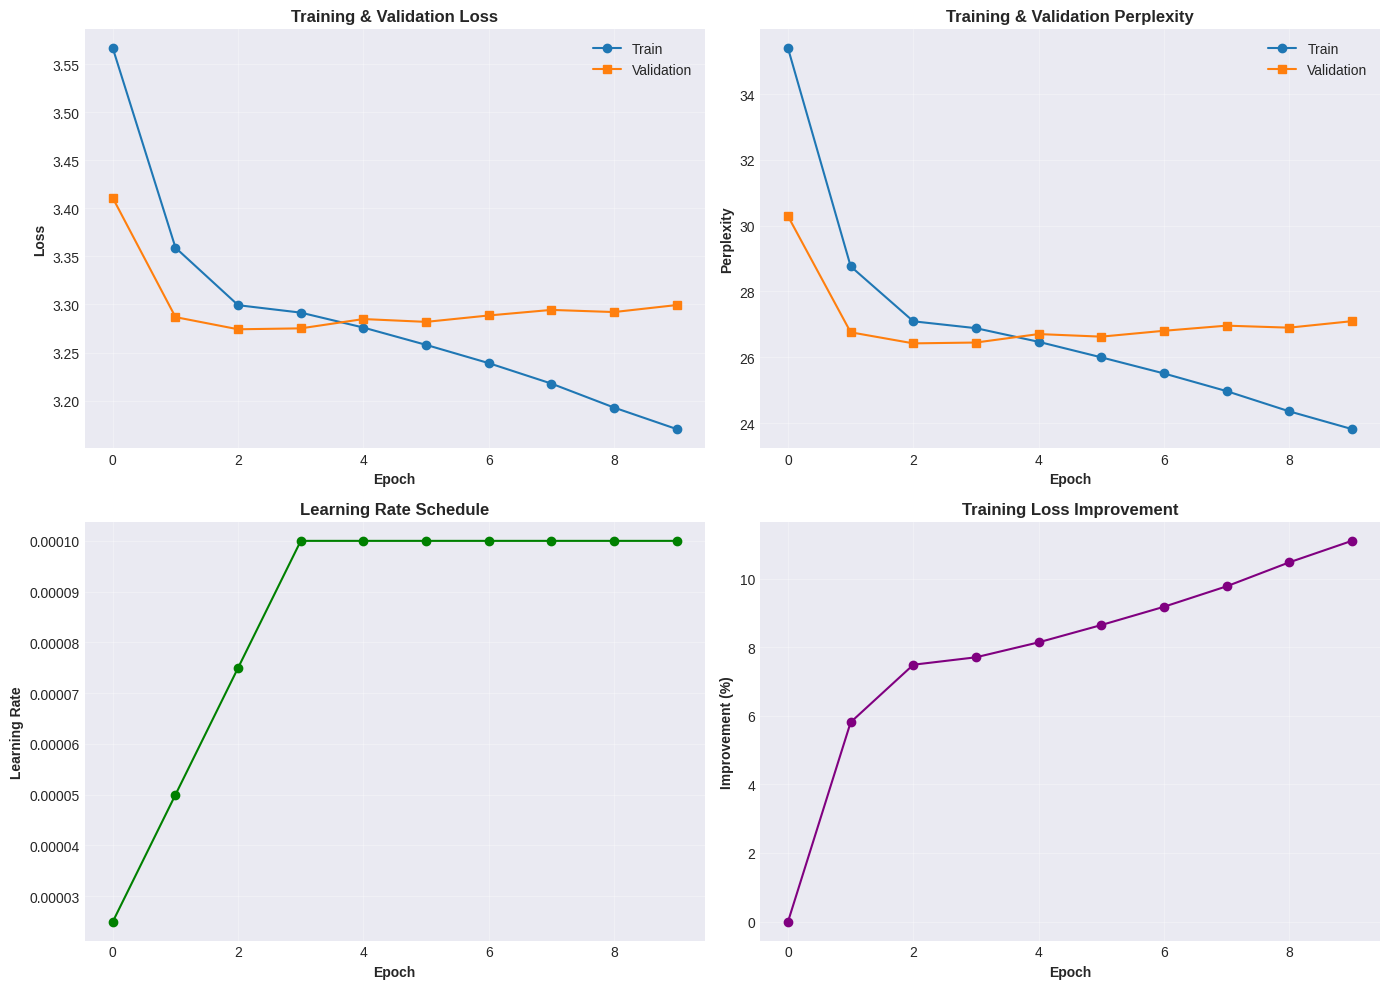


✓ Saved training history to /home/tpi/distil_shahreyar/artifacts/apache_finetune_model/training_history.csv


In [29]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss
axes[0, 0].plot(history['train_loss'], label='Train', marker='o')
axes[0, 0].plot(history['val_loss'], label='Validation', marker='s')
axes[0, 0].set_xlabel('Epoch', fontweight='bold')
axes[0, 0].set_ylabel('Loss', fontweight='bold')
axes[0, 0].set_title('Training & Validation Loss', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Perplexity
axes[0, 1].plot(history['train_ppl'], label='Train', marker='o')
axes[0, 1].plot(history['val_ppl'], label='Validation', marker='s')
axes[0, 1].set_xlabel('Epoch', fontweight='bold')
axes[0, 1].set_ylabel('Perplexity', fontweight='bold')
axes[0, 1].set_title('Training & Validation Perplexity', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Learning Rate
axes[1, 0].plot(history['lr'], marker='o', color='green')
axes[1, 0].set_xlabel('Epoch', fontweight='bold')
axes[1, 0].set_ylabel('Learning Rate', fontweight='bold')
axes[1, 0].set_title('Learning Rate Schedule', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Loss Improvement
improvement = [(history['train_loss'][0] - l) / history['train_loss'][0] * 100 for l in history['train_loss']]
axes[1, 1].plot(improvement, marker='o', color='purple')
axes[1, 1].set_xlabel('Epoch', fontweight='bold')
axes[1, 1].set_ylabel('Improvement (%)', fontweight='bold')
axes[1, 1].set_title('Training Loss Improvement', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(model_output_dir / 'training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# Save history
history_df = pd.DataFrame(history)
history_df.to_csv(model_output_dir / 'training_history.csv', index=False)
print(f"\n✓ Saved training history to {model_output_dir / 'training_history.csv'}")

## 8. Model Summary

In [30]:
# Generate model summary
summary = {
    'model': 'TemplateTransformer (Apache Fine-tuned)',
    'base_model': 'OpenStack Pre-trained',
    'training_data': 'Normal Apache logs (synthetic)',
    'vocabulary': {
        'size': apache_vocab_size,
        'total_with_special': apache_total_vocab,
        'pad_id': apache_pad_id
    },
    'architecture': {
        'd_model': model_cfg['d_model'],
        'n_layers': model_cfg['n_layers'],
        'n_heads': model_cfg['n_heads'],
        'ffn_dim': model_cfg['ffn_dim'],
        'dropout': model_cfg['dropout'],
        'max_length': max_seq_len
    },
    'training': {
        'epochs': EPOCHS,
        'batch_size': batch_size,
        'learning_rate': LEARNING_RATE,
        'warmup_steps': WARMUP_STEPS,
        'train_sequences': train_size,
        'val_sequences': val_size
    },
    'performance': {
        'best_val_loss': float(best_val_loss),
        'best_val_ppl': float(history['val_ppl'][history['val_loss'].index(min(history['val_loss']))]),
        'final_train_loss': float(history['train_loss'][-1]),
        'final_val_loss': float(history['val_loss'][-1])
    },
    'model_path': str(model_output_dir / 'best.pt')
}

with open(model_output_dir / 'model_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print(f"\n{'='*70}")
print(f"APACHE FINE-TUNED MODEL SUMMARY")
print(f"{'='*70}")
print(json.dumps(summary, indent=2))
print(f"\n✓ Model ready for Apache anomaly detection!")
print(f"\nNext steps:")
print(f"  1. Use this model in anomaly detection notebook")
print(f"  2. It now understands normal Apache patterns")
print(f"  3. Attacks should appear as deviations from learned behavior")


APACHE FINE-TUNED MODEL SUMMARY
{
  "model": "TemplateTransformer (Apache Fine-tuned)",
  "base_model": "OpenStack Pre-trained",
  "training_data": "Normal Apache logs (synthetic)",
  "vocabulary": {
    "size": 32,
    "total_with_special": 33,
    "pad_id": 32
  },
  "architecture": {
    "d_model": 256,
    "n_layers": 6,
    "n_heads": 8,
    "ffn_dim": 1024,
    "dropout": 0.1,
    "max_length": 100
  },
  "training": {
    "epochs": 10,
    "batch_size": 32,
    "learning_rate": 0.0001,
    "warmup_steps": 100,
    "train_sequences": 790,
    "val_sequences": 88
  },
  "performance": {
    "best_val_loss": 3.274148801859323,
    "best_val_ppl": 26.420726633047266,
    "final_train_loss": 3.1703701963052757,
    "final_val_loss": 3.299350490198507
  },
  "model_path": "/home/tpi/distil_shahreyar/artifacts/apache_finetune_model/best.pt"
}

✓ Model ready for Apache anomaly detection!

Next steps:
  1. Use this model in anomaly detection notebook
  2. It now understands normal Apach